---
### **Value at Risk (VaR) - The Historical Method**
---

Importing the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

Setting the **time range** for a certain amount of years.

In [2]:
years     = 15
endDate   = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

Create a list of **ticker**.

In [3]:
# SPY := Largest S&P-500 ETF
# BND := Largest bond market ETF
# GLD := Largest commodity-based ETF that tracks the price of Gold
# QQQ := Largest Nasdaq ETF
# VTI := Vanguard's all-world stock index

tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

For each of these tickers, we download the daily adjusted **close prices**.

NB: We use *adjusted close prices* rather than *normal* ones because *adjusted close prices* account for dividends stock splits and our analysis will be *more accurate* by incorporating those.

In [4]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=startDate, end=endDate)
    adj_close_df[ticker] = data['Adj Close']

adj_close_df.head(n=5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2010-02-12,82.010902,51.598305,107.040001,38.222763,41.808723
2010-02-16,83.301361,51.663418,109.620003,38.711922,42.510998
2010-02-17,83.696068,51.546211,109.250000,38.930275,42.747631
2010-02-18,84.189461,51.474586,109.980003,39.174839,42.991913
2010-02-19,84.364082,51.474586,109.470001,39.157368,43.144569


Calculate the **daily log returns** and drop any NAs.

The **simple return** (or percentage change) is calculated as:

$$
R_t = \frac{P_t}{P_{t-1}} - 1
$$

where:
- $R_t$ is the return for day \( t \),
- $P_t$ is the price at day \( t \),
- $P_{t-1}$ is the price at the previous day.

The **log return** is defined as:

$$
r_t = \ln \left(\frac{P_t}{P_{t-1}}\right)
$$

where $\ln$ represents the natural logarithm.

**Why Use Log Returns?** Logarithmic returns have an important property: **they are additive over time**.

For example, given two consecutive days' returns:

$$
r_t = \ln \left(\frac{P_t}{P_{t-1}}\right), \quad r_{t+1} = \ln \left(\frac{P_{t+1}}{P_t}\right)
$$

Adding these two:

$$
r_t + r_{t+1} = \ln \left(\frac{P_t}{P_{t-1}}\right) + \ln \left(\frac{P_{t+1}}{P_t}\right)
$$

Using the logarithmic property:

$$
\ln a + \ln b = \ln (a \cdot b)
$$

we get:

$$
r_t + r_{t+1} = \ln \left(\frac{P_{t+1}}{P_{t-1}}\right)
$$

This means that log returns can be **directly summed over multiple periods**, making them convenient for time-series analysis, portfolio aggregation, and statistical modeling. In contrast, simple returns are **not additive** but must be compounded, making calculations more complex when dealing with multiple periods.


In [5]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

log_returns.head(n=5)

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2010-02-16,0.015613,0.001261,0.023817,0.012716,0.016658
2010-02-17,0.004727,-0.002271,-0.003381,0.005625,0.005551
2010-02-18,0.005878,-0.001390,0.006660,0.006262,0.005698
2010-02-19,0.002072,0.000000,-0.004648,-0.000446,0.003545
2010-02-22,0.000180,-0.000380,-0.003661,-0.002009,-0.001593


Create an **equally weighted portfolio**.

In [6]:
# Assume a portfolio value of $1M, equally weighted.
portfolio_value = 1000000
weights         = np.array([1 / len(tickers)] * len(tickers))

Calculate the **historical portfolio returns** based on our equally weighted portfolio.

In [7]:
historical_returns = (log_returns * weights).sum(axis=1)
historical_returns

Date
2010-02-16    0.014013
2010-02-17    0.002050
2010-02-18    0.004622
2010-02-19    0.000104
2010-02-22   -0.001493
                ...   
2025-02-03   -0.003178
2025-02-04    0.007460
2025-02-05    0.004896
2025-02-06    0.001477
2025-02-07   -0.006426
Length: 3770, dtype: float64

Find the X-days historical returns. We:
- Set a 5-day period.
- Create a DataFrame based on 5-days rolling returns.

We aim to compute the **rolling cumulative returns** over a specified period (**X days**), allowing us to analyze short-term return trends instead of just daily fluctuations.

We first calculate the **daily weighted portfolio returns**:

$$
\text{historical returns} = \sum_{i=1}^{n} w_i \cdot r_i
$$

where:
- $w_i$ = portfolio weight of asset $i$,
- $r_i$ = daily log return of asset $i$,
- The sum is taken **across all assets** for each day.

To compute **X-day cumulative returns**, we use a **rolling sum** over the daily returns:

$$
R_t = \sum_{j=t-X+1}^{t} r_j
$$

where:
- $R_t$ is the **X-day cumulative return at time $t$**,
- $r_j$ are the **individual daily returns** in the rolling window,
- The window moves **day by day**, always summing the last X days.

**Why Use a Rolling Sum?**
- **Smooths out daily volatility** by aggregating past returns.
- **Reveals short-term trends** in portfolio performance.
- **Useful for risk and momentum analysis** in trading and investment strategies.

In [8]:
days = 5
historical_x_day_returns = historical_returns.rolling(window = days).sum()
historical_x_day_returns = historical_x_day_returns.dropna()

Specify a confidence interval and calculate VaR.

The general mathematical definition of **VaR at a confidence level $1 - \alpha$** is:

$$
VaR_{1-\alpha}(X) := \inf \{ t \in \mathbb{R} : \Pr(X \leq t) \geq 1 - \alpha \}
$$

where:
- $X$ represents the distribution of portfolio returns,
- $t$ is the threshold return (percentile cutoff),
- $\alpha$ is the **significance level** (e.g., 5% for a 95% confidence interval),
- $1 - \alpha$ is the **confidence level** (e.g., 95%),
- The **infimum (inf)** ensures we take the smallest possible value meeting the probability condition.

**Formula Used in the Historical Method**: The **historical method** directly takes past return data and calculates the percentile corresponding to the chosen confidence level. The formula is:

$$
VaR = -\text{Percentile} ( X, 100 \times (1 - \alpha) ) \times \text{Portfolio Value} 
$$

where:
- $X$ is the **historical return distribution**,
- $\alpha$ is the **significance level**,
- $\text{Percentile} (X, 100 \times (1 - \alpha))$ gives the **cutoff return** for the worst $\alpha$% of cases,
- The **negative sign** ensures that VaR is expressed as an absolute loss.

In [9]:
confidence_interval = 0.95
VaR = -np.percentile(historical_x_day_returns, 100-(confidence_interval*100))*portfolio_value

print(VaR)

23966.564533462046


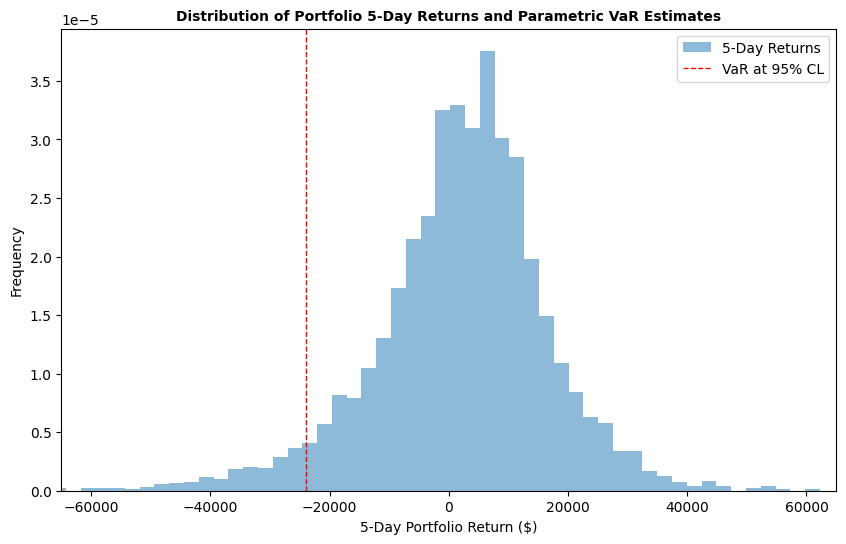

In [10]:
historical_x_day_returns_dollars = historical_x_day_returns * portfolio_value

plt.figure(figsize=(10, 6))

plt.hist(historical_x_day_returns_dollars, bins=100, density=True, alpha=0.5, label=f'{days}-Day Returns')
plt.axvline(-VaR, color='red', linestyle='dashed', linewidth=1, label=f'VaR at {int(confidence_interval * 100)}% CL')

# Formatting labels and title
plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates', fontsize=10, fontweight='bold')

plt.xlim(left=-65000, right=65000)
plt.legend()
plt.show()

The histogram represents the **empirical distribution of portfolio returns over 5 days** using the **historical method** for Value at Risk (**VaR**) estimation. The **blue bars** show the **frequency of past gain/loss scenarios**, derived directly from historical returns without assuming a specific distribution. The **red dashed line** indicates the **VaR threshold at 95% confidence**, marking the **5% worst historical losses**. Unlike the parametric approach, which relies on statistical assumptions, this method **uses actual past data** to estimate risk. This visualization helps assess **downside risk** by identifying extreme losses based on historical market behavior.